# Experimentos con DCGAN y Clasificador STAMP.

In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as data_utils
from src.utils.stamp_loader import get_SN_dataset, get_full_dataset, get_training_loaders
import os 
# Dataset Loading
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import os 
# DCGAN
from src.dcgan import DCGAN
from src.config import parse_args
# Generation and visualization
from torchvision import utils
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# Torch transformation for image preprocessing
resolution = 32
trans = transforms.Compose([
    transforms.Resize(resolution),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset_directory = os.getcwd() + "/datasets/stamp/"
train_dataset, test_dataset = get_SN_dataset(dataset_directory,file_name="stamp_dataset_only_images_63.pkl", transform=trans)

In [ ]:
# Loading DCGAN-MODEL
args = parse_args()
dcgan = DCGAN(args)
dcgan.load_model("./dcgan_models/discriminator.pkl", "./dcgan_models/generator.pkl")

In [2]:
# Generation of images and visualization tools
def unnormalize_images(images):
    images = images.mul(0.5).add(0.5)
    return images

def generate_images(n_imgs=64):
    z = torch.randn(n_imgs, 100, 1, 1)
    samples = dcgan.G(z)
    samples = unnormalize_images(samples)
    samples = samples.data.cpu()
    return samples


def show(imgs, save_img=True, filename="output.pdf"):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), interpolation="none")
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if save_img:
        fig.tight_layout()
        fig.savefig("./imgs/"+filename, dpi=200)
    

In [3]:
real_images, _ = train_dataset[np.random.choice(len(train_dataset), 64)]
real_images = unnormalize_images(real_images)
fake_images = generate_images(64)
sz = fake_images.shape
fake_images_sep = [fake_images[:, i, :, :] .view(sz[0],1,sz[2],sz[3]) for i in range(3)]
real_images_sep = [real_images[:, i, :, :] .view(sz[0],1,sz[2],sz[3]) for i in range(3)]
fake_images_grids = [utils.make_grid(s) for s in fake_images_sep]
real_images_grids = [utils.make_grid(s) for s in real_images_sep]

print("Real Images - Channels separated")
show(real_images_grids, filename="real_1_channel.pdf")
print("Fake Images - Channels separated")
show(fake_images_grids, filename="fake_1_channel.pdf")

NameError: name 'train_dataset' is not defined

Real vs Generated RGB Images


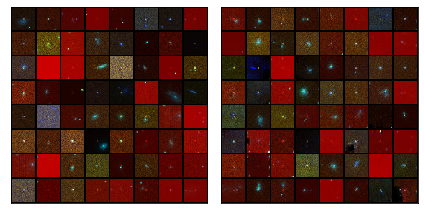

In [ ]:
real_images, _ = train_dataset[np.random.choice(len(train_dataset), 64)]
real_images = unnormalize_images(real_images)
fake_images = generate_images(64)
real_images_grid = utils.make_grid(real_images)
fake_images_grid = utils.make_grid(fake_images)

print("Real vs Generated RGB Images")
show([real_images_grid, fake_images_grid], filename="real_fake_dcgan_rgb.pdf")

In [ ]:
from src.stamp_classifier import trainer

#Learning parameters
resolution = 28
batch_size = 32

# Torch transformation for image preprocessing
trans = transforms.Compose([
    transforms.Resize(resolution)
])

dataset_directory = os.getcwd() + "/datasets/stamp/"
train_dataset, test_dataset = get_full_dataset(dataset_directory,file_name="stamp_dataset_28.pkl")

train_dataloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = data_utils.DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

In [4]:
curves_data = {}
epochs = 200
images_generate_list = [18000]
required_size = (28, 28)

for n in images_generate_list:
  num_img = n
  if n == 0:
    fake_dcgan = torch.tensor([])
  else:
    fake_dcgan = generate_images(n_imgs=num_img)
    fake_dcgan = torch.nn.functional.interpolate(fake_dcgan, size=required_size, mode='bilinear', align_corners=False)
    dataset_directory = os.getcwd() + "/datasets/stamp/"

  train_loader,val_loader = get_training_loaders(dataset_directory, synthetic_SN=fake_dcgan.detach().cpu(), 
                                                batch_size=32, file_name="stamp_dataset_28.pkl", label_as_strings=False,
                                                  with_labels=True)
  
  print(f"Imagenes generadas:{num_img} - Tamaño de clases:",torch.bincount(train_loader.dataset.labels.to(torch.int)))
  curves = trainer(train_loader, val_loader, epochs=epochs, n_generated=num_img)
  curves_data[num_img] = curves_data

NameError: name 'dcgan' is not defined